In [1]:
import sys
import os
# Add "mitsuba" library path to the system path
root = os.path.abspath('../..')
sys.path.insert(0, os.path.abspath(f'{root}/ext/mitsuba3/build/python'))

# Import mitsuba and set the variant
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
import mitsuba as mi
mi.set_variant('llvm_rgb')

# Import the mitsuba-transient extension
# adds extra functionality to existing Mitsuba classes
import mitransient as mitr

In [2]:
# Load XML file
# You can also use mi.load_dict and pass a Python dict object
# but it is probably much easier for your work to use XML files
scene = mi.load_file(os.path.abspath('nlos_Z.xml'))

# Prepare transient integrator for transient path tracing
# Does the work to initialize the scene before path tracing
transient_integrator = scene.integrator()
transient_integrator.prepare_transient(scene, sensor=0)
# sensor=0 just tells it to use the first sensor in the scene
# (in case there is more than one sensor in the XML file)

# Render the scene and develop the data
# Because mitsuba works with Dr.JIT, this cell will execute
# very fast. But when you actually read the variables
# it will actually start computing everyting (and take a while).
data_steady, data_transient = transient_integrator.render(scene)

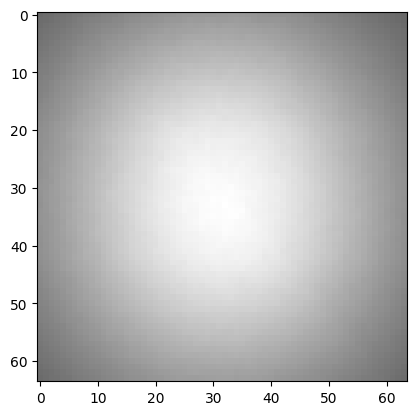

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# show data_steady (apply gamma tone mapping)
gamma = 1.0 / 2.2

# you cannot see much in data_steady because it's the sum over
# the temporal domain for the data captured at the relay wall
# so there is no temporal information
# the temporal information is what allows you
# to see around corners easier :)
plt.imshow((data_steady / np.max(data_steady)) ** gamma)
plt.show()

In [4]:
# data_transient is a 4D array representing in Dr.JIT's TensorXf class
# It is very similar to a numpy array (in fact, you can convert between
# the two by using np.array(data_transient))
print(data_transient.__class__.__name__)
# The channels represent (x, y, time, rgb)
print(data_transient.shape)

TensorXf
(64, 64, 300, 3)


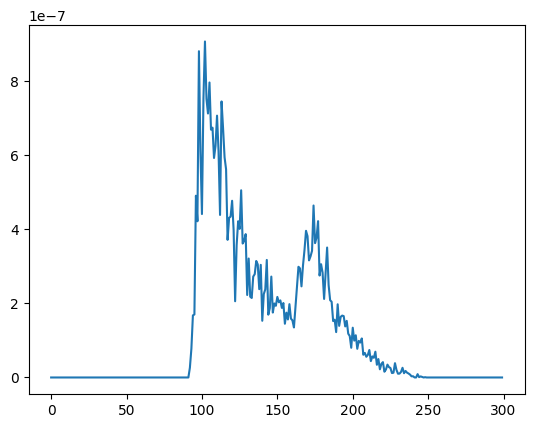

In [5]:
# There are two main ways of plotting data_transient
# The first one is to plot a single pixel's time-resolved response
plt.plot(np.array(data_transient)[0, 0, :, 0])

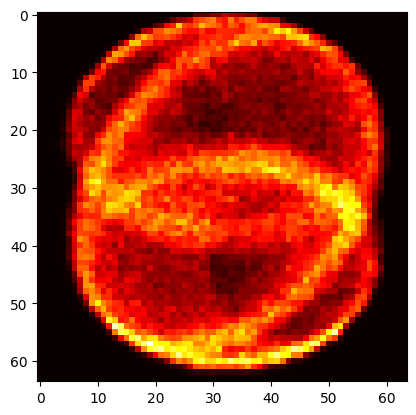

In [6]:
# The second one is to plot a frame of the transient video
# To understand this image, you can look at the paper:
# Non-Line-of-Sight Transient Rendering, Figure 4
plt.imshow(np.fliplr(np.array(data_transient)[:, :, 60, 0].T), cmap='hot')

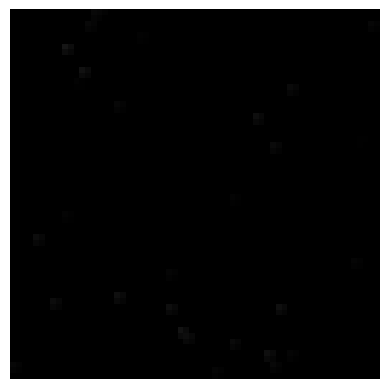

In [7]:
# Mitsuba transient offers a utility function to show videos
# although it is mostly unused in NLOS simulations
gamma = 1.0 / 4.0
data_max = np.max(data_transient)
mitr.utils.show_video((np.moveaxis(data_transient, 0, 1) / data_max) ** gamma, 2)